# Grad-Cam Results

In [3]:
#%pip install torch torchvision matplotlib seaborn opencv-python wilds ipykernel lightning-lite pytorch-lightning==1.8.6
!source ../CFE/bin/activate

In [6]:
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import cv2
from wilds import get_dataset
from torchvision.transforms import ToTensor, Normalize, Compose, CenterCrop, Resize
from torchvision.models import resnet50
from utils.datasets import BinaryDataset
from utils.datasets import SpuCoDogsDataset
import warnings 
warnings.filterwarnings('ignore')

In [7]:
class VGGWithGradCAM(torch.nn.Module):
    def __init__(self, model):
        super(VGGWithGradCAM, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:30]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

class AlexNetWithGradCAM(torch.nn.Module):
    def __init__(self, model):
        super(AlexNetWithGradCAM, self).__init__()
        
        # get the pretrained AlexNet network
        self.alexnet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.alexnet.features[:12]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.alexnet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

class ResNetWithGradCAM(nn.Module):
  def __init__(self, model):
    super(ResNetWithGradCAM, self).__init__()

    self.model = model
    self.feature_extractor = nn.Sequential(*list(self.model.children())[:-2]) # we take layers before the classifier and the avgpool
    self.avgpool = self.model.avgpool
    self.out = self.model.fc
    # placeholder for the gradients
    self.gradients = None

  def forward(self, x, reg_hook=True):
      x = self.feature_extractor(x)

      # register hook (needed for grad-cam)
      if reg_hook:
        x.register_hook(self.activations_hook)

      x = self.avgpool(x)

      x = x.view(x.shape[0], -1)  # reshape the tensor
      x = self.out(x)
      return x

  # hook for the gradients of the activations
  def activations_hook(self, grad):
      self.gradients = grad

  def get_activations_gradient(self):
      return self.gradients
  
  def get_activations(self, x):
      return self.feature_extractor(x)
     


Method: Original
Predicted label: Big Dog, True label: Small Dog


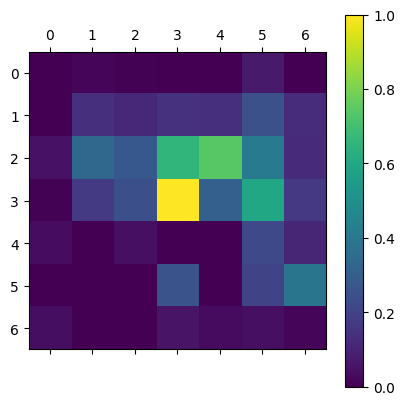

In [44]:
if __name__ == "__main__":
    transform = Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = 'SpuCO_dogs'
    norm = 'Original'
    #sample_idx = 89

    for sample_idx in range(202, 203):
        if dataset == 'WaterBirds':
            main_dataset = get_dataset(dataset="waterbirds", download=False,root_dir='../SCRATCH/')
            data = main_dataset.get_subset("val", transform=transform)
            data = BinaryDataset(data,which_dataset='waterbirds')
            
            data_to_visualize = main_dataset.get_subset("val", transform=None)
            data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False, num_workers=2)

            state_dict = torch.load(f'../SCRATCH/CFE_models/WaterBirds_trained_model.pt')
            #torch.load(f"../SCRATCH/CFE_datasets/WaterBirds_{norm}", map_location='cpu', weights_only=False)['adv_classifier']
            state_dict = OrderedDict((k.replace('model.resnet.', '', 1), v) for k, v in state_dict.items())
            
            resnet50_model = resnet50().cuda()
            resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features,1)
            
            resnet50_model.load_state_dict(state_dict)
            model = ResNetWithGradCAM(resnet50_model).cuda()
            model.zero_grad()
            model.eval()

            iter_dataloader = iter(data_loader)
            for i in range(sample_idx + 1):
                img, target = next(iter_dataloader)

            Class = 'Landbird' if target.float() == 0 else 'Waterbird' 
            model.zero_grad()
            pred = model(img.cuda())
            target = torch.tensor([-1.0]).cuda() if target.item() == 0 else target
            predi = pred * target.cuda()
            predi.backward()

            gradients = model.get_activations_gradient()
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            activations = model.get_activations(img.cuda()).detach()
            
            for i in range(activations.size(1)):
                activations[:, i, :, :] *= pooled_gradients[i]
            
            heatmap = torch.mean(activations.cpu(), dim=1).squeeze()
            heatmap = np.maximum(heatmap, 0)
            heatmap /= torch.max(heatmap)
            
            plt.matshow(heatmap.squeeze())
            plt.colorbar()
            
            raw_image = data_to_visualize[sample_idx][0]
            raw_image.save(f'results/GradCAM/WaterBirds/WaterBirds_Original_{Class}.jpg')
            
            img = cv2.imread(f'results/GradCAM/WaterBirds/WaterBirds_Original_{Class}.jpg')
            heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed_img = heatmap * 0.4 + img
            cv2.imwrite(f'results/GradCAM/WaterBirds/WaterBirds_{norm}_{Class}_heatmap.jpg', superimposed_img)

            predicted_label = "WaterBird" if pred.sigmoid().item() > 0.5 else "LandBird"
            print(f"Predicted label: {predicted_label}, True label: {Class}")
        
        elif dataset == 'SpuCO_dogs':
            data = SpuCoDogsDataset('../SCRATCH/spuco_dogs/test', transform=transform)
            data_to_visualize = SpuCoDogsDataset('../SCRATCH/spuco_dogs/test', transform=None)
            
            state_dict = torch.load(f'../SCRATCH/CFE_models/SpuCO_dogs_trained_model_seed_20.pt') if norm == 'Original' else torch.load(f'../SCRATCH/CFE_models/SpuCO_dogs_{norm}_seed_20')
            #torch.load(f"../SCRATCH/CFE_datasets/WaterBirds_{norm}", map_location='cpu', weights_only=False)['adv_classifier']
            state_dict = OrderedDict((k.replace('model.resnet.', '', 1), v) for k, v in state_dict.items())
            
            resnet50_model = resnet50().cuda()
            resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features,2)
            
            resnet50_model.load_state_dict(state_dict)
            model = ResNetWithGradCAM(resnet50_model).cuda()
            model.zero_grad()
            model.eval()

            img, target = data[sample_idx][:2]

            Class = 'Big Dog' if target == 1 else 'Small Dog' 
            model.zero_grad()
            out = model(img.unsqueeze(0).cuda())
            pred = out.argmax(dim=1)
            out[:, int(pred.item())].backward()

            gradients = model.get_activations_gradient()
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            activations = model.get_activations(img.unsqueeze(0).cuda()).detach()
            
            for i in range(activations.size(1)):
                activations[:, i, :, :] *= pooled_gradients[i]
            
            heatmap = torch.mean(activations.cpu(), dim=1).squeeze()
            heatmap = np.maximum(heatmap, 0)
            heatmap /= torch.max(heatmap)
            
            plt.matshow(heatmap.squeeze())
            plt.colorbar()
            
            raw_image = data_to_visualize[sample_idx][0]
            raw_image.save(f'./results/GradCAM/SpuCO_dogs_Original_{Class}_sample_{sample_idx}.jpg')
            
            img = cv2.imread(f'results/GradCAM/SpuCO_dogs_Original_{Class}_sample_{sample_idx}.jpg')
            heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed_img = heatmap * 0.4 + img
            cv2.imwrite(f'results/GradCAM/SpuCO_dogs_{norm}_{Class}_sample_{sample_idx}_heatmap.jpg', superimposed_img)

            predicted_label = "Big Dog" if pred.item() == 1 else "Small Dog"
            print(f'Method: {norm}')
            print(f"Predicted label: {predicted_label}, True label: {Class}")

        else:
            NotImplementedError